In [1]:
!pip install -r requirements.txt

You should consider upgrading via the '/home/jules/Documents/rbm_recommender/venv/bin/python -m pip install --upgrade pip' command.


In [20]:
import gzip
from json import loads
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import display  # removes unnecessary error reports in PyCharm
from scipy import sparse
from tqdm import tqdm


tqdm.pandas()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Using device", device)

Using device cuda


In [3]:
def parse_json(filename: str, read_max: int = None) -> pd.DataFrame:
    """
    Reads the file line by line, parsing each line as json.
    """
    file = gzip.open(filename, "r")
    data = []
    for index, line in enumerate(tqdm(file)):
        if index == read_max:
            break
        data.append(loads(line))
    print(f"Read {len(data)} rows.")
    return pd.DataFrame.from_dict(data)

# Dataset

The dataset consists of three separate files:

- The books; we will only need this data to make sense of the recommendations. Using this data to make recommendations
is (at least for now) not required for the project. It would require analysis and comparisons of the books, which is not
a part of the base algorithm. However, being able to show which books are being recommended, rather than just showing an
ID, is quite valuable in itself.

- The reviews; this file contains all the reviews and associated ratings that the users have given. This is essentially
the explicit feedback that we can use to generate recommendations.

- The interactions; this file contains all the interactions between users and books. It contains explicit and implicit
feedback, both of which we can use to generate recommendations. We will probably only use the implicit data if we do use
the data in this file.

We have the option of using either explicit (i.e. ratings) or implicit (i.e. interactions) data. Because the paper
discusses the prediction of ratings, this is also what we will be doing.

The following cells load the data from the files and convert them into the appropriate types. This includes parsing
datetime strings, converting integers to numpy types, etc.

## Important variables/settings

- *n* determines the maximum number of rows read from any of the files.
- *datafile*, which can be either `interactions` or `reviews`, determines the file from which the data matrix will be
read.
- *k* determines the number of predictions the recommender will make, and on how many predictions it will be evaluated,
e.g. by using `Recall@k`.
- *epochs* determines the number of epochs we will use to train the recommender.

In [4]:
data_path = "data/"
books = "goodreads_books_comics_graphic.json.gz"
interactions = "goodreads_interactions_comics_graphic.json.gz"
reviews = "goodreads_reviews_comics_graphic.json.gz"
datasets = {books: None, reviews: None}  # interactions: None,

n = None
datafile = reviews
k = 10
epochs = 20

for filename in datasets.keys():
    print(filename)
    datasets[filename] = parse_json(data_path + filename, n)
    display(datasets[filename].head(5))

books_df = datasets[books][["book_id", "title"]].copy()
interactions_df = datasets[datafile][["user_id", "book_id", "rating", "date_updated"]].copy()

goodreads_books_comics_graphic.json.gz


89411it [00:05, 15153.09it/s]


Read 89411 rows.


,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,,1,[],US,,"[{'count': '228', 'name': 'to-read'}, {'count'...",B00NLXQ534,true,4.12,,...,,,,https://www.goodreads.com/book/show/25742454-t...,https://s.gr-assets.com/assets/nophoto/book/11...,25742454,1,42749946,The Switchblade Mamma,The Switchblade Mamma
1,2205073346,2,[],US,fre,"[{'count': '2', 'name': 'bd'}, {'count': '2', ...",,false,3.94,,...,1,,2016,https://www.goodreads.com/book/show/30128855-c...,https://images.gr-assets.com/books/1462644346m...,30128855,16,50558228,Cruelle,Cruelle
2,,5,"[246830, 362583, 362581, 623032]",US,eng,"[{'count': '493', 'name': 'to-read'}, {'count'...",,false,4.28,,...,,,2012,https://www.goodreads.com/book/show/13571772-c...,https://images.gr-assets.com/books/1333287305m...,13571772,51,102217,Captain America: Winter Soldier (The Ultimate ...,Captain America: Winter Soldier (The Ultimate ...
3,,1,[],US,eng,"[{'count': '222', 'name': 'to-read'}, {'count'...",B06XKGGSB7,true,4.05,B06XKGGSB7,...,,,,https://www.goodreads.com/book/show/35452242-b...,https://s.gr-assets.com/assets/nophoto/book/11...,35452242,6,54276229,Bounty Hunter 4/3: My Life in Combat from Mari...,Bounty Hunter 4/3: My Life in Combat from Mari...
4,0930289765,6,"[266759, 1096220]",US,en-US,"[{'count': '20', 'name': 'to-read'}, {'count':...",,false,4.06,,...,11,,1997,https://www.goodreads.com/book/show/707611.Sup...,https://images.gr-assets.com/books/1307838888m...,707611,51,693886,"Superman Archives, Vol. 2","Superman Archives, Vol. 2"


goodreads_reviews_comics_graphic.json.gz


542338it [00:05, 92195.40it/s]


Read 542338 rows.


,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,dc3763cdb9b2cae805882878eebb6a32,18471619,66b2ba840f9bd36d6d27f46136fe4772,3,Sherlock Holmes and the Vampires of London \n ...,Thu Dec 05 10:44:25 -0800 2013,Thu Dec 05 10:45:15 -0800 2013,Tue Nov 05 00:00:00 -0800 2013,,0,0
1,bafc2d50014200cda7cb2b6acd60cd73,6315584,72f1229aba5a88f9e72f0dcdc007dd22,4,"I've never really liked Spider-Man. I am, howe...",Wed Aug 10 06:06:48 -0700 2016,Fri Aug 12 08:49:54 -0700 2016,Fri Aug 12 08:49:54 -0700 2016,Wed Aug 10 00:00:00 -0700 2016,0,0
2,bafc2d50014200cda7cb2b6acd60cd73,29847729,a75309355f8662caaa5e2c92ab693d3f,4,"A very quick introduction, this is coming out ...",Thu Apr 21 07:44:00 -0700 2016,Thu Apr 21 07:59:28 -0700 2016,Thu Apr 21 07:59:28 -0700 2016,Thu Apr 21 00:00:00 -0700 2016,0,0
3,bafc2d50014200cda7cb2b6acd60cd73,18454118,c3cc5a3e1d6b6c9cf1c044f306c8e752,5,I've been waiting so long for this. I first st...,Mon Mar 03 17:45:56 -0800 2014,Mon Mar 03 17:54:11 -0800 2014,Sat Mar 01 00:00:00 -0800 2014,Sat Mar 01 00:00:00 -0800 2014,1,0
4,bafc2d50014200cda7cb2b6acd60cd73,2239435,cc444be37ab0a42bfb4dd818cb5edd10,4,The only thing more entertaining than this boo...,Wed Apr 03 12:37:48 -0700 2013,Wed Apr 03 13:03:36 -0700 2013,Wed Apr 03 13:03:36 -0700 2013,,0,0


In [5]:
format_str = "%a %b %d %H:%M:%S %z %Y"
interactions_df["date_updated"] = pd.to_datetime(interactions_df["date_updated"], format=format_str)

books_df["book_id"] = books_df["book_id"].astype("int64")
interactions_df["book_id"] = interactions_df["book_id"].astype("int64")

interactions_df = interactions_df.sort_values(by=["user_id", "date_updated"], ascending=[True, True])

# Preprocessing

We apply the following preprocessing steps:

- Reconsumption item removal, although there aren't many (or even none at all) of these in the dataset.

- Infrequent item removal; we remove any items that have less than a certain number (5) of interactions/ratings.

- Infrequent user removal; we remove users with less that the same certain number (5) of interactions/ratings.

In [6]:
def preprocess(df: pd.DataFrame, min_support: int = 5) -> pd.DataFrame:
    """
    Removes reconsumption items, items that have less than `min_support` interactions, and users that have less than
    `min_support` interactions. In some cases, removing an infrequent item may turn a frequent user into an infrequent
    one, and vice versa. In these cases, we don't remove the now infrequent user/item, we only consider the original
    frequency. As such, the preprocessed dataset may contain some users and items that don't reach the minimum support
    limit.
    """
    print(df.shape[0], "initial rows")
    # Drop reconsumption items
    df = df.drop_duplicates(subset=["user_id", "book_id"])
    print(df.shape[0], "rows after removing reconsumption items")
    # Compute user and item counts
    g1 = df.groupby("book_id", as_index=False)["user_id"].size()
    g1 = g1.rename({"size": "users_per_item"}, axis="columns")
    g2 = df.groupby("user_id", as_index=False)["book_id"].size()
    g2 = g2.rename({"size": "items_per_user"}, axis="columns")
    df = pd.merge(df, g1, how="left", on=["book_id"])
    df = pd.merge(df, g2, how="left", on=["user_id"])
    # Drop items and users with less than `min_support` interactions
    df = df[(df["users_per_item"] >= min_support) & (df["items_per_user"] >= min_support)]
    print(df.shape[0], "rows after removing infrequent items and users")
    df.drop(columns=["users_per_item", "items_per_user"], inplace=True)
    return df


display(interactions_df.head(10))
print(f"Number of unique users:", interactions_df["user_id"].nunique())
print(f"Number of unique items:", interactions_df["book_id"].nunique())
processed_df = preprocess(interactions_df)
print(f"Number of unique users:", processed_df["user_id"].nunique())
print(f"Number of unique items:", processed_df["book_id"].nunique())
display(processed_df.head(10))

,user_id,book_id,rating,date_updated
498184,00009e46d18f223a82b22da38586b605,23546829,3,2016-01-15 19:31:35-08:00
54004,000192962b87d560f00b06fdcbd71681,30025791,5,2017-01-28 09:56:08-08:00
541427,0003a8eb2989503d03ad7ca701898a48,23479604,0,2015-05-29 08:00:12-07:00
541426,0003a8eb2989503d03ad7ca701898a48,15780398,2,2015-05-29 08:02:05-07:00
541425,0003a8eb2989503d03ad7ca701898a48,22738008,0,2015-05-29 08:04:06-07:00
255717,0005a08accd53b1e19c52109a1f478cb,1472402,5,2007-09-16 21:21:34-07:00
255716,0005a08accd53b1e19c52109a1f478cb,119162,4,2008-04-11 01:09:21-07:00
255715,0005a08accd53b1e19c52109a1f478cb,3285607,5,2008-05-12 19:27:12-07:00
255714,0005a08accd53b1e19c52109a1f478cb,59960,0,2008-09-09 18:23:53-07:00
255713,0005a08accd53b1e19c52109a1f478cb,107037,3,2011-07-20 10:58:49-07:00


Number of unique users: 59347
Number of unique items: 89311
542338 initial rows
542338 rows after removing reconsumption items
367781 rows after removing infrequent items and users
Number of unique users: 16326
Number of unique items: 19029


,user_id,book_id,rating,date_updated
5,0005a08accd53b1e19c52109a1f478cb,1472402,5,2007-09-16 21:21:34-07:00
7,0005a08accd53b1e19c52109a1f478cb,3285607,5,2008-05-12 19:27:12-07:00
8,0005a08accd53b1e19c52109a1f478cb,59960,0,2008-09-09 18:23:53-07:00
13,0006260f85929db85eddee3a0bd0e504,29869650,4,2016-05-11 04:53:09-07:00
14,0006260f85929db85eddee3a0bd0e504,29521992,5,2016-10-07 05:08:26-07:00
20,0008931c0cde961e9c802c5a58196d23,6081685,5,2013-03-09 07:02:48-08:00
21,0008931c0cde961e9c802c5a58196d23,7311068,5,2013-03-09 07:03:42-08:00
22,0008931c0cde961e9c802c5a58196d23,6690979,5,2013-03-09 07:05:26-08:00
24,0008931c0cde961e9c802c5a58196d23,6599344,5,2014-01-26 10:16:17-08:00
25,0008931c0cde961e9c802c5a58196d23,6372263,5,2014-01-26 10:19:19-08:00


In [7]:
def apply_consecutive_mapping(dataframe: pd.DataFrame, column: str, new_column: str, *additional: pd.DataFrame) -> None:
    """
    Generates a consecutive ID column for the values of an existing column. Also adds this column to additional data
    frames with the exact same mapping of old ID to new (consecutive) ID.
    """
    ids = {}

    def map_to_consecutive_ids(uuid: Union[int, np.int64]) -> int:
        """
        To be used with `pd.Dataframe.apply()` or `pd.Dataframe.progress_apply()`; returns a unique ID per distinct
        value.
        """
        if uuid not in ids:
            ids[uuid] = len(ids)
        return ids[uuid]

    dataframe[new_column] = dataframe[column].progress_apply(map_to_consecutive_ids)
    for frame in additional:
        frame[new_column] = frame[column].progress_apply(lambda old_id: ids.get(old_id, -1))


apply_consecutive_mapping(processed_df, "user_id", "user_id_int")
apply_consecutive_mapping(processed_df, "book_id", "book_id_int", books_df)
processed_df = processed_df[["user_id_int", "book_id_int", "date_updated", "rating"]]
processed_df = processed_df.rename(
    columns={"user_id_int": "user_id", "book_id_int": "item_id", "date_updated": "datetime"})

display(books_df.head(10))
display(processed_df.head(10))

100%|██████████| 89411/89411 [00:00<00:00, 1173644.31it/s]


,book_id,title,book_id_int
0,25742454,The Switchblade Mamma,-1
1,30128855,Cruelle,-1
2,13571772,Captain America: Winter Soldier (The Ultimate ...,-1
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,-1
4,707611,"Superman Archives, Vol. 2",-1
5,2250580,"A.I. Revolution, Vol. 1",7820
6,27036536,"War Stories, Volume 3",-1
7,27036537,"Crossed, Volume 15",-1
8,27036538,"Crossed + One Hundred, Volume 2 (Crossed +100 #2)",-1
9,27036539,"War Stories, Volume 4",-1


,user_id,item_id,datetime,rating
5,0,0,2007-09-16 21:21:34-07:00,5
7,0,1,2008-05-12 19:27:12-07:00,5
8,0,2,2008-09-09 18:23:53-07:00,0
13,1,3,2016-05-11 04:53:09-07:00,4
14,1,4,2016-10-07 05:08:26-07:00,5
20,2,5,2013-03-09 07:02:48-08:00,5
21,2,6,2013-03-09 07:03:42-08:00,5
22,2,7,2013-03-09 07:05:26-08:00,5
24,2,8,2014-01-26 10:16:17-08:00,5
25,2,9,2014-01-26 10:19:19-08:00,5


In [8]:
def split(items: list[int], percentage_train: float) -> pd.Series:
    nr_train_items = int(len(items) * percentage_train)
    return pd.Series((items[: nr_train_items], items[nr_train_items:]))


sessions_df = processed_df.groupby(by="user_id", as_index=False)[["item_id", "datetime", "rating"]].agg(list)
display(sessions_df.head(5))

percentage_train = 0.8
sessions_df[["item_id_history", "item_id_future"]] = sessions_df["item_id"].progress_apply(split,
                                                                                           args=(percentage_train,))
sessions_df[["rating_history", "rating_future"]] = sessions_df["rating"].progress_apply(split, args=(percentage_train,))
display(sessions_df.head(5))

,user_id,item_id,datetime,rating
0,0,"[0, 1, 2]","[2007-09-16 21:21:34-07:00, 2008-05-12 19:27:1...","[5, 5, 0]"
1,1,"[3, 4]","[2016-05-11 04:53:09-07:00, 2016-10-07 05:08:2...","[4, 5]"
2,2,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]","[2013-03-09 07:02:48-08:00, 2013-03-09 07:03:4...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]"
3,3,"[17, 18, 19, 20, 21]","[2017-04-04 12:19:56-07:00, 2017-04-06 10:10:5...","[5, 5, 5, 5, 5]"
4,4,"[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]","[2016-03-04 06:02:24-08:00, 2016-07-23 01:02:4...","[3, 4, 3, 3, 3, 2, 1, 3, 3, 3, 4, 3]"


100%|██████████| 16326/16326 [00:02<00:00, 6951.34it/s] 


,user_id,item_id,datetime,rating,item_id_history,item_id_future,rating_history,rating_future
0,0,"[0, 1, 2]","[2007-09-16 21:21:34-07:00, 2008-05-12 19:27:1...","[5, 5, 0]","[0, 1]",[2],"[5, 5]",[0]
1,1,"[3, 4]","[2016-05-11 04:53:09-07:00, 2016-10-07 05:08:2...","[4, 5]",[3],[4],[4],[5]
2,2,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]","[2013-03-09 07:02:48-08:00, 2013-03-09 07:03:4...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]","[5, 6, 7, 8, 9, 10, 11, 12, 13]","[14, 15, 16]","[5, 5, 5, 5, 5, 5, 5, 5, 5]","[5, 5, 5]"
3,3,"[17, 18, 19, 20, 21]","[2017-04-04 12:19:56-07:00, 2017-04-06 10:10:5...","[5, 5, 5, 5, 5]","[17, 18, 19, 20]",[21],"[5, 5, 5, 5]",[5]
4,4,"[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]","[2016-03-04 06:02:24-08:00, 2016-07-23 01:02:4...","[3, 4, 3, 3, 3, 2, 1, 3, 3, 3, 4, 3]","[22, 23, 24, 25, 26, 27, 28, 29, 30]","[31, 32, 33]","[3, 4, 3, 3, 3, 2, 1, 3, 3]","[3, 4, 3]"


In [9]:
def create_sparse_matrix(dataframe: pd.DataFrame, item_id_column: str, value_column: str = None,
                         shape: tuple[int, int] = None) -> sparse.csr_matrix:
    """
    Creates a sparse matrix from the data in `dataframe`.
    """
    # Flatten the dataframe
    user_ids = []
    item_ids = []
    values = []
    for index, row in dataframe.iterrows():
        user_ids.extend([row["user_id"]] * len(row[item_id_column]))
        item_ids.extend(row[item_id_column])
        if value_column is not None:
            values.extend(row[value_column])
    if value_column is None:
        values = np.ones(len(user_ids))
    # Create the CSR matrix
    return sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)


shape = (processed_df["user_id"].max() + 1, processed_df["item_id"].max() + 1)
train = create_sparse_matrix(sessions_df, "item_id_history", "rating_history", shape)
true = create_sparse_matrix(sessions_df, "item_id_future", "rating_future", shape)
# train = create_sparse_matrix(sessions_df, "item_id_history", None, shape)
# true = create_sparse_matrix(sessions_df, "item_id_future", None, shape)

# Evaluation

The evaluation metrics we will be using are the following:

- Recall @ 10: the percentage of users where the top-10 recommendations are relevant.

- NDCG @ 10: similar to recall but the sum of the hits is weighted by the place in the top 10.

- Qualitative results, i.e. examples of the recommendations.

In [10]:
def sparse_invert_nonzero(a: sparse.csr_matrix) -> sparse.csr_matrix:
    inverse = a.copy()
    inverse.data = 1 / inverse.data
    return inverse


def sparse_divide_nonzero(a: sparse.csr_matrix, b: sparse.csr_matrix) -> sparse.csr_matrix:
    return a.multiply(sparse_invert_nonzero(b))


def compute_recall(true: sparse.csr_matrix, predicted: sparse.csr_matrix) -> float:
    scores = sparse.lil_matrix(predicted.shape)
    scores[predicted.multiply(true).astype(bool)] = 1
    scores = sparse_divide_nonzero(scores.tocsr(), sparse.csr_matrix(true.sum(axis=1))).sum(axis=1)
    return scores.mean()

# recall = compute_recall(true, predicted)
# print(f"Recall @ {k}: {recall:.4f}")

# RBM-based recommender

In [11]:
from tqdm.notebook import tqdm, trange


class RBM:

    def __init__(self, nr_visible: int, nr_hidden: int, learning_rate: float) -> None:
        self.weights = torch.randn(nr_visible, nr_hidden).to(device)
        self.bias_items = torch.randn(nr_visible).to(device)
        self.bias_features = torch.randn(nr_hidden).to(device)
        self.learning_rate = learning_rate

    def prob_hidden(self, visible: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(visible @ self.weights + self.bias_features)

    def prob_visible(self, hidden: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(hidden @ self.weights.t() + self.bias_items)

    @staticmethod
    def sample(probabilities: torch.Tensor) -> torch.Tensor:
        return torch.bernoulli(probabilities)

    def update(self, visible_0: torch.Tensor, visible_k: torch.Tensor, prob_hidden_0: torch.Tensor,
               prob_hidden_k: torch.Tensor) -> None:
        self.weights += self.learning_rate * (visible_0.t() @ prob_hidden_0 - visible_k.t() @ prob_hidden_k)
        self.bias_items += self.learning_rate * (visible_0 - visible_k).sum(0)
        self.bias_features += self.learning_rate * (prob_hidden_0 - prob_hidden_k).sum(0)

    def fit(self, visible_0: torch.Tensor, sampling_iterations: int = 1) -> torch.Tensor:
        visible_k = visible_0
        for _ in range(sampling_iterations):
            hidden_k = self.sample(self.prob_hidden(visible_k))
            visible_k = self.sample(self.prob_visible(hidden_k))
            visible_k[visible_0 < 0] = visible_0[visible_0 < 0]
        prob_hidden_0 = self.sample(self.prob_hidden(visible_0))
        prob_hidden_k = self.sample(self.prob_hidden(visible_k))
        self.update(visible_0, visible_k, prob_hidden_0, prob_hidden_k)
        return visible_k

    def predict_(self, data: torch.Tensor, k: int = 10) -> tuple[np.ndarray, np.ndarray]:
        hidden = self.sample(self.prob_hidden(data))
        probabilities = self.prob_visible(hidden)
        probabilities[data >= 0] = 0
        probabilities = probabilities.cpu().numpy()
        items = np.argpartition(-probabilities, k, 1)[:, :k]
        scores = probabilities[np.repeat(np.arange(data.shape[0]), k), items.flatten()]
        return items, scores.reshape(items.shape)

    def predict(self, data: sparse.csr_matrix, k: int = 10, batch_size: int = 1024) -> sparse.csr_matrix:
        user_ids = []
        item_ids = []
        scores = []
        for batch_start in trange(0, data.shape[0], batch_size, leave=False):
            batch = self.convert(data[batch_start: batch_start + batch_size])
            predictions, prediction_scores = self.predict_(batch, k)
            user_ids.extend(np.repeat(range(batch_start, min(batch_start + batch_size, data.shape[0])), k))
            item_ids.extend(predictions.flatten())
            scores.extend(prediction_scores.flatten())
        return sparse.csr_matrix((scores, (user_ids, item_ids)), shape=data.shape)

    @staticmethod
    def convert(data: sparse.csr_matrix) -> torch.Tensor:
        tensor = torch.Tensor(data.toarray()).to(device)
        tensor[tensor == 0] = -1
        tensor[tensor == 1] = 0
        tensor[tensor == 2] = 0
        tensor[tensor >= 3] = 1
        return tensor

In [18]:
rbm = RBM(train.shape[1], 2000, 0.01)

epochs = 20
batch_size = 50
recall = []
train_loss = []
rmse_loss = []

tqdm.write(f"Epoch | Train loss | RMSE loss  | Recall@{k}")
for epoch in tqdm(range(epochs), leave=False):
    train_loss.append(0)
    rmse_loss.append(0)

    for batch_start in trange(0, train.shape[0], batch_size, leave=False):
        batch = rbm.convert(train[batch_start: batch_start + batch_size])
        reconstruction = rbm.fit(batch)
        train_loss[-1] += (batch[batch >= 0] - reconstruction[batch >= 0]).abs().sum()
        rmse_loss[-1] += ((batch[batch >= 0] - reconstruction[batch >= 0]) ** 2).sum()

    current_predictions = rbm.predict(train)
    recall.append(compute_recall(true, current_predictions))
    train_loss[-1] = (train_loss[-1] / train.shape[0]).item()
    rmse_loss[-1] = (rmse_loss[-1] / train.shape[0]).sqrt().item()

    tqdm.write(f"{epoch + 1:<5} | {train_loss[-1]:10.7} | {rmse_loss[-1]:10.7} | {recall[-1]:10.7}")

Epoch | Train loss | RMSE loss  | Recall@10


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

1     |   6.695822 |   2.587629 | 0.0002656982


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

2     |   6.795112 |   2.606744 | 0.001104588


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

3     |   6.670403 |   2.582712 | 0.0001676271


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

4     |   6.754992 |   2.599037 | 0.00107709


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

5     |   6.346808 |   2.519287 | 0.002592702


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

6     |   6.034239 |   2.456469 | 0.004010082


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

7     |   5.795602 |   2.407406 | 0.003931034


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

8     |   5.667707 |   2.380695 | 0.0009443008


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

9     |   5.558434 |   2.357633 | 0.007763507


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

10    |   5.362673 |   2.315745 | 0.008972334


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

11    |   5.192576 |   2.278723 | 0.009724421


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

12    |    5.14535 |   2.268337 | 0.009027378


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

13    |   4.956572 |   2.226336 | 0.01026115


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

14    |   4.870084 |   2.206827 | 0.01027222


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

15    |   4.778574 |   2.185995 | 0.009198324


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

16    |   4.787149 |   2.187955 | 0.009468903


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

17    |   4.712912 |   2.170924 | 0.009217094


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

18    |   4.569888 |    2.13773 | 0.008157039


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

19    |   4.498223 |   2.120902 | 0.007795913


  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

20    |   4.440279 |   2.107197 | 0.007880855


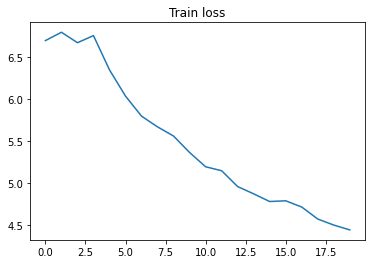

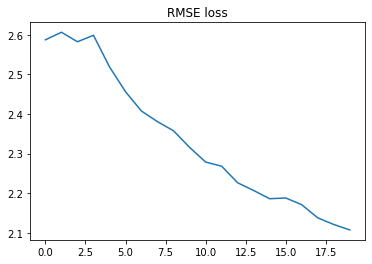

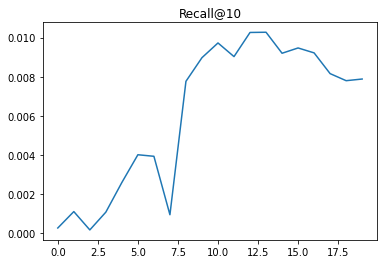

In [23]:
plt.plot(range(1, epochs + 1), train_loss)
plt.title("Train loss")
plt.show()

plt.plot(range(1, epochs + 1), rmse_loss)
plt.title("RMSE loss")
plt.show()

plt.plot(range(1, epochs + 1), recall)
plt.title(f"Recall@{k}")
plt.show()